In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Stream

In this section we will work on a much bigger data set, of 25M ratings. This data set can be found on https://grouplens.org/datasets/movielens/.

Note that in this data set, there are no features on the users, meaning that **we cannot apply the Disjoint Linear UCB algorithm there**.

In [2]:
data_stream = pd.read_csv('../data/ml-25m/ratings.csv')
data_stream

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [3]:
# We rename the columns userId and movieId to adapt them to our existing functions
data = data_stream.rename(columns={"userId": "user_id", "movieId": 'movie_id'}).copy()

# Same thing, we only keep the movies that have more than 20000 reviews
# We chose 20000 because it reduces the number of different movies to 202, where for a bound of 1000,
# there are 3790 different movies and for a bound of 10000, there is still 588.
# Reducing to 202 movies greatly improve our performences as the number of arms gets lower, while 
# still keeping more that 6.5 millions observations which is 25 times more than with our small database of work
movie_counts = data['movie_id'].value_counts()
selected_movies = movie_counts[movie_counts > 20000].index
data = data[data['movie_id'].isin(selected_movies)].reset_index(drop=True)

# We resample
data = data.sample(frac=1).reset_index(drop=True)

# Add time columns
data['time'] = data.index

# Add the binary rating
data['binary_rating'] = data['rating'].apply(lambda x: 1 if x == 5 else 0)

# We keep a version with rating, we will use it for our EXP3 algorithm
#df_rating = data[['time', 'movie_id', 'user_id', 'rating', 'binary_rating']].copy()

# We compute our new rating system to keep it between 0 and 1 included
#df_rating['rating'] = (df_rating['rating']-1)/4

# Lastly, we reorder the columns and get rid of rating and timestamp
df = data[['time', 'movie_id', 'user_id', 'binary_rating']].copy()

df

,time,movie_id,user_id,binary_rating
0,0,6874,15777,0
1,1,79132,32273,0
2,2,4027,122337,1
3,3,318,95641,0
4,4,1393,35282,0
...,...,...,...,...
6589710,6589710,1210,12275,1
6589711,6589711,541,134780,1
6589712,6589712,380,54232,0
6589713,6589713,1732,61593,0


We check the proportion of 1s (previously 5) in our binary rating :

In [4]:
df['binary_rating'].sum()/len(df)

0.2197729340343247

We can also plot a graph to see the repartition of ratings

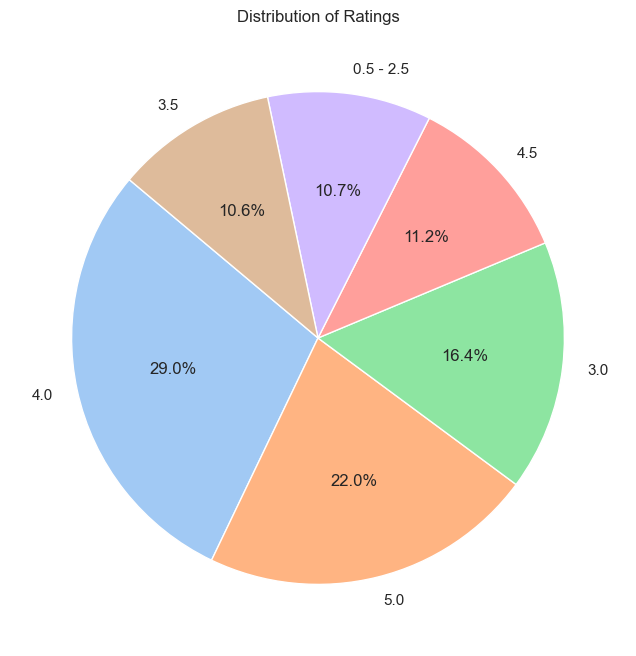

In [10]:
# We combine all the ratings between 0.5 and 2.5 included since there are only a few of them
data['new_rating'] = data['rating'].apply(lambda x: "0.5 - 2.5" if x < 3 else x)

note_counts = data['new_rating'].value_counts()

sns.set(style="whitegrid")

plt.figure(figsize=(8, 8))
plt.pie(note_counts, labels=note_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title('Distribution of Ratings')

plt.savefig('camembert_25m_data.png')

# Lightweight baby
plt.show()

So there is 22% of 1s, let's hope that our algorithm do better...

## Epsilon Greedy Policy

In [4]:
from epsilon_greedy import policy_evaluator_epsilon

payoffs_epsilon = policy_evaluator_epsilon(df, epsilon_value = 0.15)

pd.DataFrame(payoffs_epsilon).to_csv('epsilon_greedy_0.15.csv')


epsilon greedy begins
progression : 10 %
progression : 20 %
progression : 30 %
progression : 40 %
progression : 50 %
progression : 60 %
progression : 70 %
progression : 80 %
progression : 90 %


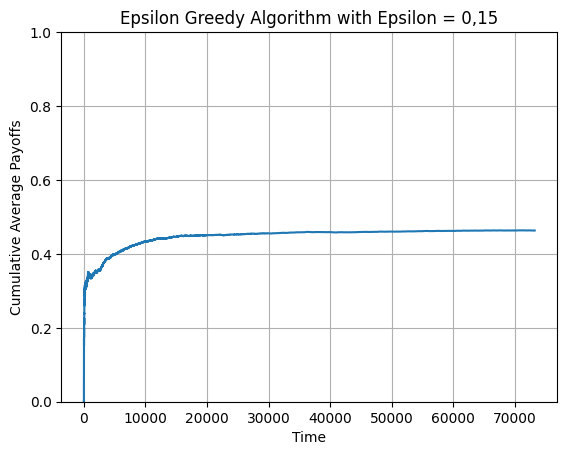

In [13]:
cumulative_average_epsilon = np.cumsum(payoffs_epsilon) / np.arange(1, len(payoffs_epsilon)+1)

plt.plot(cumulative_average_epsilon)
plt.xlabel("Time")
plt.ylabel("Cumulative Average Payoffs")
plt.title("Epsilon Greedy Algorithm with Epsilon = 0,15")
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('epsilon_greedy_0.15.png', dpi=300)
plt.show()


## Moss Anytime Policy

In [4]:
from moss_anytime import policy_evaluator_moss_anytime_min

# The number of loops are the number of epochs
# We are working with 2 epochs, because MOSS doesn't have time to converge on a single iteration
payoffs_moss = policy_evaluator_moss_anytime_min(df, alpha=1.35, loops = 2)

pd.DataFrame(payoffs_moss).to_csv('moss_anytime_1.35_2_epochs.csv')


moss anytime begins
progression : 10 %
progression : 20 %
progression : 30 %
progression : 40 %
progression : 50 %
progression : 60 %
progression : 70 %
progression : 80 %
progression : 90 %
progression : 100 %
moss anytime begins


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

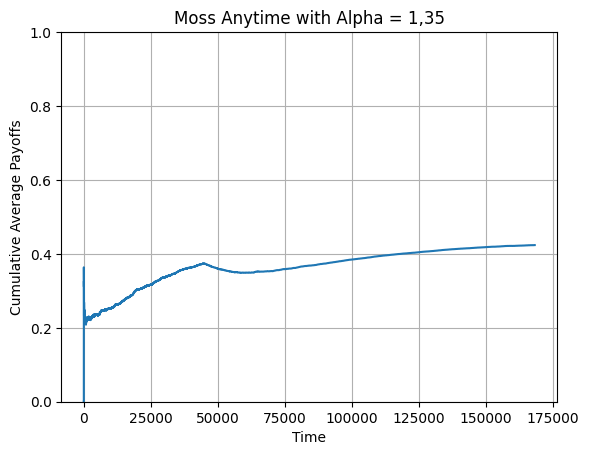

In [9]:
cumulative_average_moss = np.cumsum(payoffs_moss) / np.arange(1, len(payoffs_moss)+1)

plt.plot(cumulative_average_moss)
plt.xlabel("Time")
plt.ylabel("Cumulative Average Payoffs")
plt.title("Moss Anytime with Alpha = 1,35")
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('moss_anytime_1.35_2_epochs.png', dpi = 300)
plt.show()


## EXP3 Policy

In [7]:
from exp3 import policy_evaluator_EXP3

# The number of loops are the number of epochs
payoffs_exp3 = policy_evaluator_EXP3(df_rating, eta=0.7, loops=3)

pd.DataFrame(payoffs_exp3).to_csv('exp3_0.7_3_epochs.csv')


exp3 begins
Epoch  0
progression : 10 %
progression : 20 %
progression : 30 %
progression : 40 %
progression : 50 %
progression : 60 %
progression : 70 %
progression : 80 %
progression : 90 %
Epoch  1
progression : 10 %
progression : 20 %
progression : 30 %
progression : 40 %
progression : 50 %
progression : 60 %
progression : 70 %
progression : 80 %
progression : 90 %
Epoch  2
progression : 10 %
progression : 20 %
progression : 30 %
progression : 40 %
progression : 50 %
progression : 60 %
progression : 70 %
progression : 80 %
progression : 90 %


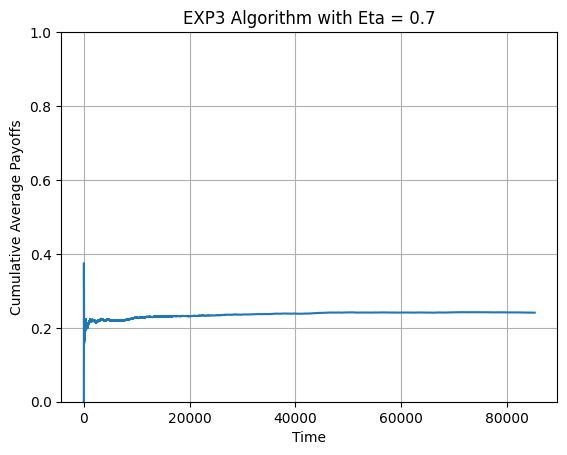

In [8]:
cumulative_average_exp3 = np.cumsum(payoffs_exp3) / np.arange(1, len(payoffs_exp3)+1)

plt.plot(cumulative_average_exp3)
plt.xlabel("Time")
plt.ylabel("Cumulative Average Payoffs")
plt.title("EXP3 Algorithm with Eta = 0.7")
plt.ylim(0, 1)
plt.grid(True)

plt.savefig('exp3_0.7_3_epochs.png', dpi = 300)
plt.show()
